# Modelamiento de categorías con el método "Asignación Latente de Dirichlet" para las opiniones de los usuarios de una aplicación móvil

Las opiniones y calificaciones que los usuarios dan a los productos digitales son una fuente importante de información para sus desarrolladores, ya que permiten identificar elementos que se deben mejorar para favorecer la adopción y retención de nuevos usuarios. Sin embargo, a medida que la cantidad de opiniones de usuarios incrementa, se hace más dificil clasificar los temas en torno a los cuales giran las oportunidades de mejora. Si esta tarea se hiciera manualmente, asumiendo un tiempo promedio de treinta segundos por opinión, se requeriría un poco más de ocho horas de trabajo para la revisión de mil opiniones. 

En el presente trabajo se presentan los resultados de aplicar una técnica no supervisada de Procesamiento del Lenguaje Natural para identificar los principales temas contenidos en más trece mil opiniones de usuarios de una aplicación móvil. Primero, se presenta el conjunto de datos utilizado, obtenidos a través de un proceso de "scraping" del sitio web GooglePlay. Seguidamente, se realiza una limpieza y preprocesamiento de los datos para encontrar las palabras más relevantes para la solución del problema. Posteriormente, se implementa un modelo conocido como "Asignación Latente de Dirichlet" para la identificación de los temas contenidos en las opiniones de los usuarios. Por último, se presentan los resultados y se hacen recomendaciones prácticas sobre el proceso de sintonización (tuning) del modelo.

## 1. Librerías utilizadas

En adición a las librerías típicamente utilizadas para el procesamiento y visualización de datos (Pandas, Seaborn y Matplotlib), se utilizaron las bibliotecas NLTK (Natural Language Toolkit) y Spacy para las tareas de limpieza y pre-procesamiento del lenguaje natural, y la librería BeautifulSoup para el "scraping" de datos. Por su parte, la librería Gensim fue utilizada para la implementación del modelo de Asignación Latente de Dirichlet (ALD), encargado de hacer el modelamiento de los temas contenidos en el conjunto de datos. Todas las librerías utilizadas hacen parte de proyectos de código abierto.

#### Código:

In [32]:
# Librerías para procesamiento y visualización de datos
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Librería usada para hacer "scraping" de páginas web en formato HTML
from bs4 import BeautifulSoup

# Librerías para limpieza y pre-procesamiento del lenguaje natural
import nltk
from nltk.corpus import stopwords
import string
import unidecode

# Librería para el "Etiquetado Gramatical" y la "Lematización" de los datos
# ( Part-of-speech tagging (POS), Lemmatization )
import spacy
import es_core_news_sm

# Librería usada el "Modelado de Temas" mediante la "Asignación Latente de Dirichlet" 
# ( Topic Modelling-Latent Dirichlet Allocation (LDA) )
import gensim
from gensim import corpora

## 2. Conjunto datos

Los datos fueron obtenidos mediante un proceso de "scraping" del sitio web GooglePlay. Corresponden a opiniones de los usuarios de la aplicación Android de Rappi, calificadas con una y dos estrellas. Se utilizan opiniones con baja calificación asumiendo que son las que contienen más información sobre elementos para mejorar en el producto. En total, el conjunto de datos contiene 13558 opiniones.

#### Código:

Funciones de ayuda para el "scraping" de datos:

In [24]:
def load_soup(page_path):
    
    ''' Retorna un objeto "BeautifulSoup" que contiene la información de la página web de 
        trabajo y con el cual se realiza el "scraping" de las opiniones de los usuarios '''
    
    file_name = page_path
    with open(file_name) as f:
        return BeautifulSoup(f, 'html.parser')


def scrape_reviews(soup):    
    
    ''' Retorna una lista con las opiniones de los usuarios presentes en la página web de trabajo '''
    
    # Tag que contiene todas las opiniones de usuarios presentes en la página web
    tags = soup.find_all("div", {"class": "UD7Dzf"})
    reviews = []
    for tag in tags:
        # Opiniones largas, obtenidas después de presionar el botón "Ver opinión completa"
        review = tag.find('span',{"jsname":"fbQN7e"}).getText()
        if review == '':
            # Opiniones cortas que no requieren el botón "Ver opinión completa"
            review = tag.find('span',{"jsname":"bN97Pc"}).getText()
        reviews.append(review)
    return reviews

Extracción de opiniones:

In [25]:
# Extrae las opiniones calificadas con una estrella. 
# La página web está guardada localmente en formato html
one_star_html_path = 'data/web_pages/rappi/one_star/rappi_one_star.html'
one_star_soup = load_soup(one_star_html_path)
one_star_reviews = scrape_reviews(one_star_soup)

# Extrae las opiniones calificadas con dos estrellas
# La página web está guardada localmente en formato html
two_star_html_path = 'data/web_pages/rappi/two_star/rappi_two_star.html'
two_star_soup = load_soup(two_star_html_path)
two_star_reviews = scrape_reviews(two_star_soup)

# Exporta todas las opiniones a un archivo csv
all_reviews = one_star_reviews + two_star_reviews
df_reviews = pd.DataFrame(all_reviews, columns=['review'])
df_reviews.to_csv('data/web_pages/rappi/rappi_reviews.csv', index=False)

#### Resultados

In [33]:
# Carga las opiniones desde archivo csv
path = "data/web_pages/rappi/rappi_reviews.csv"
df = pd.read_csv(path, encoding='utf-8')

In [34]:
# Muestra las primeras cinco opiniones del conjunto de datos
df.head()

,review
0,"Ha desmejorado mucho, antes era excelente, aho..."
1,"Listo, actualizado y nada, no es mi tarjeta es..."
2,Las promos con tarjeta te las reintegran algun...
3,"Horrible, nunca descarguen esta aplicación. Al..."
4,Edito reseña: soporte es pésimo al fin logre i...


In [28]:
# Muestra la cantidad de opiniones contenidas en el conjunto de datos
df.shape

(13558, 1)

## 3. Frecuencias de Tokens (primera iteración)

Un token es definido como una secuencia continua de caracteres ubicada entre dos espacios. De esta manera, un token puede ser una palabra, un signo de puntuación, caracteres especiales, etc.  Conocer cuáles son los tokens que se presentan con mayor frecuencia en el conjunto de datos permite tener una idea de los temas en torno a los cuales giran las opiniones de los usuarios.

El siguiente código permite mostrar en un gráfico de barras los tokens más frecuentes en el conjunto de datos.

#### Código:

Función de ayuda para graficar los tokens más frecuentes en el conjunto de datos:

In [35]:
def plot_top_freq_tokens(data, n=20):
    
    ''' Grafica los n tokens más frecuentes en conjunto de datos de opiniones de los usuarios '''
    
    # Obtiene los token más frecuentes
    words = ' '.join([word for word in data])
    tokenized_words = nltk.word_tokenize(words)
    freqDist = nltk.FreqDist(tokenized_words)
    top_n_df = pd.DataFrame(freqDist.most_common(n), columns=['Token', 'Recuento'])
    
    # Muestra los tokens más frecuentes en un gráfico de barras
    plt.figure(figsize=(20,6))
    ax = sns.barplot(data=top_n_df, x= "Token", y = "Recuento")
    title = 'Frecuencias de los Tokens Contenidos en el Conjunto de Opiniones de Usuarios (Top {})'.format(n)
    ax.set(title = title)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    plt.show()

#### Resultados:

El gráfico de barras a continuación muestra los 20 tokens más frecuentes en el conjunto de datos. Estos tokens corresponden en su mayoría a signos de puntuación, artículos, pronombres personales o preposiciones del español. Los tokens mostrados son poco útiles para el modelamiento de temas, ya que no entregan información relevante sobre las necesidades de los usuarios.

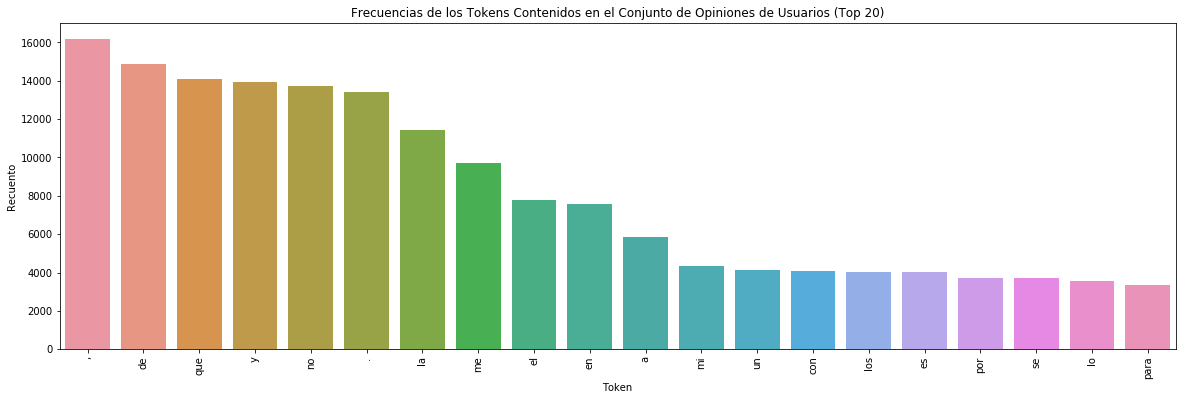

In [8]:
plot_top_freq_tokens(df['review'])

## 4. Remoción de las palabras de parada, signos de puntuación y palabras cortas

En consecuencia con el resultado anterior, el primer paso en el preprocesamiento del conjunto de datos será la eliminación de los tokens que no son relevantes para el problema planteado.

En este sentido, a continuación se removerán los siguientes tokens:
- **Palabras de parada (stop words):** son las palabras más comunes del idioma. Algunos ejemplos son "algo", "como", "cuando" o "contra". Para eliminarlas se utiliza el listado de palabras de parada del español de la librería NLTK.
- **Tokens cortos (longitud menor a 3 caracteres)**
- **Signos de puntuación**

Adicionalmente, se estandarizan todos los tokens en letras minúsculas.

#### Código:

Función de ayuda para remover palabras de parada:

In [36]:
def remove_stopwords(review):
    
    ''' Remueve las palabras de parada una opinión de usuario '''
    
    return " ".join([token for token in review if token not in stop_words])

Remoción de tokens poco relevantes:

In [37]:
# Carga las palabras de parada de la librería NLTK
stop_words = stopwords.words('spanish')

# Remover los tokens cortos (longitud menor a tres caracteres)
df['review'] = df['review'].apply(lambda x: ' '.join([token for token in nltk.word_tokenize(x) if len(token)>2]))

# Remover las palabras de parada
reviews = [remove_stopwords(nltk.word_tokenize(review)) for review in df['review']]

# Remover los signos de puntuación
reviews = [r.translate(str.maketrans('', '', string.punctuation)) for r in pd.Series(reviews)]

# Estandarizar todo en minúsculas
reviews = [review.lower() for review in reviews]

## 5. Frecuencias de Tokens (segunda iteración)

Los siguientes dos gráficos de barras muestran el top 20 y 50 de las palabras más comunes en el conjunto de datos, después de remover los tokens menos relevantes.

En los gráficos se observan palabras como pedido, cobertura, servicio, tarjeta, efectvo, entre otras. Esta palabras se pueden relacionar con problemas que experimentan los usuarios de la aplicación.

Sin embargo, aún se pueden observar palabras poco relevantes como "dice", "solo" o "hacer". Además, algunas palabras con significados cercanos como "pedido" y "pedidos" también forman parte de las palabras más frecuentes.

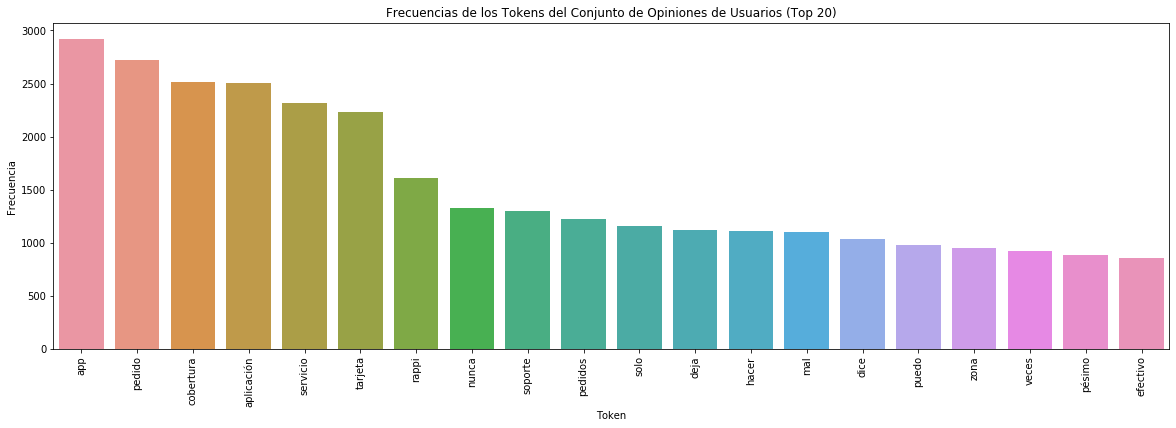

In [21]:
plot_top_freq_tokens(reviews)

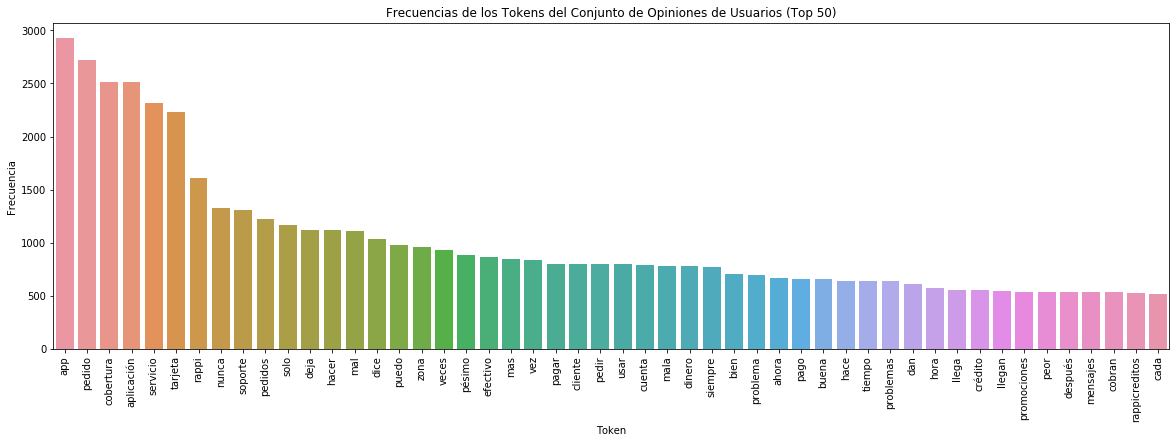

In [22]:
plot_top_freq_tokens(reviews, 50)

## 6. Etiquetado gramatical y lematización

Esta sección continúa con el preprocesamiento de la información, implementando dos filtros para las palabras del conjunto de datos.

En primer lugar, se remueven todas las palabras que no sean sustantivos, adjetivos, verbos o adverbios. Esta tarea se realiza para continuar con la remoción de palabras poco relevantes para el modelo.

Posteriormente se realiza la lematización de las palabras. Gracias a este proceso se consigue, por ejemplo, que "dije", "diré" y "dijéramos" sean reemplazadas por "decir"; o "pedido" y "pedidos" se reemplacen por "pedido". Es decir, la lematización puede entenderse como un proceso de estandarización de palabras con significados similares a una palabra "base" o "lema".

La implementación de estos filtros se realiza con la librería de procesamiento del lenguaje natural Spacy.

#### Código

Funciones de ayuda para filtrar las palabras por sustantivos, adjetivos, verbos o adverbios, y obtener los lemas de las palabras resultantes.

In [61]:
def is_noun_adj_verb_adv(pos_tag):
    
    ''' Verifica si una palabra es un sustantivo, adjetivo, verbo o adverbio  '''
    
    return pos_tag == 'NOUN' or pos_tag == 'ADJ' or pos_tag == 'VERB' or pos_tag == 'ADV'


def get_lemmas(text):
    
    ''' Retorna los lemas de los sustantivos, adjetivos, verbos y adverbios 
        contenidos en las opiniones de los usuarios '''
    
    npl_text = spanish_npl(text)
    nouns_adjs = [token.lemma_ for token in npl_text if is_noun_adj_verb_adv(token.pos_)]
    return ' '.join(nouns_adjs)

In [58]:
# Carga el paquete de procesamiendo del lenguaje natural de español de la librería Spacy
spanish_npl = es_core_news_sm.load()

In [59]:
# Transforma las opiniones de los usuarios para que contengan solo los lemas de las
# palabras más relevantes
reviews_lemma = pd.DataFrame(pd.Series(reviews).apply(get_lemmas), columns=['review'])

#### Resultado

A continuación se muestra un ejemplo de una opinión de usuario después de pasar por el proceso de lematización y etiquetado gramatcal. Se observa que las palabras resultantes son explícitas en cuando a las necesidades del usuario.

In [62]:
reviews_lemma['review'][1]

'listar actualizar tarjeta app además cobrar servicio dar acepto método pagar tarjeta solo decir verificar luego malo aplicación atención ausentar cuartar vez usar rappi mejor ir comer personalmente'

## 7. Modelamiento

En su aplicación para problemas de texto, el método de Asignación Latente de Dirichlet opera bajo un par de suposiciones. En primer lugar, funciona sobre la idea de "bolsa de palabras", es decir, asume que los textos son colecciones de palabras sin una estructura gramatical definida. Por otra parte, el modelo asume que los documentos (opiniones, en este caso) que componen un cuerpo de texto (conjunto de opiniones), están compuesto por un número n de temas o categorías, y que cada categoría, a su vez, está compuesta por un conjunto w de palabras. La asignación de las palabras a cada una de las categorías se hace siguiendo un proceso iterativo que considera una distribución de Dirichlet. El número de temas o categorías debe ser definido e ingresado al modelo antes de su ejecución.

Descripciones detalladas del modelo se pueden encontrar en [1] y [2].

#### Código:

El primer paso es la tokenización de las palabras de cada opinión de usuario:

In [43]:
tokenized_lemma_reviews = reviews_lemma['review'].apply(lambda x: x.split())

Posteriormente las palabras tokenizadas se guardan en una estrucura de datos tipo diccionario de la librería Gensim. Esta estructura asigna un índice númerico para cada palabra del conjunto de datos [3].

In [44]:
dictionary = corpora.Dictionary(tokenized_lemma_reviews)

A continuación se implementa el último filtro a las opiniones de usuario, omitiendo las palabras que aparecen menos de diez veces (es decir, palabras raras), y las palabras que aparecen en más del 40% de las opiniones. Estas últimas, al ser tan comunes, reduce la capacidad de diferenciar entre las categorías del modelo.

In [ ]:
dictionary.filter_extremes(no_below=10, no_above=0.4)
dictionary.compactify()

El siguiente pasa es transformar el conjunto de opiniones a una bolsa de palabras [4], de acuerdo a lo que requiere el modelo:

In [ ]:
doc_term_matrix = [dictionary.doc2bow(rev) for rev in tokenized_lemma_reviews]

Finalmente, todos los elementos calculados son incluído en el modelo para su ejecución. Los parámetros num_topics, chunksize y passes son escogidos de acuerdo a la sintonización del modelo. Un valor de random_state constante permite obterner las mimas distribuciones de probabilidad en diferentes ejecuciones del modelo.

In [45]:
# Crea un objeto ALD de la librerí Gensim
LDA = gensim.models.ldamodel.LdaModel

# Construye el modelo ALD
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=5, random_state=100, 
                chunksize=1000, passes=100)

## 8. Resultados y recomendaciones

#### Código:

Función de ayuda para obtener las primeras n palabras (de acuerdo a su probabilidad) de las categorías obtenidas con el modelo ALD:

In [121]:
def get_top_topic_words(number_topics, n=20):
    
    ''' Retorna los n primeros tokens de la categorías obtenidas con el método ALD  '''
    
    words = {}
    for t in range(number_topics):
            topic = lda_model.show_topic(t, topn=n)
            topic_words = []
            for i in range(n):
                word =  topic[i][0]
                topic_words.append(word)
            topic_name = 'Categoría_{}'.format(t)
            words[topic_name] = topic_words
    return pd.DataFrame(words)

#### Resultados

En la tabla siguiente se muestran las 20 primeras palabras de cada categoría obtenida. De acuerdo a los resultados, las categorías pueden clasificarse así:

- **Categoría 0 (Pagos):** Incluye palabras como "pagar", "tarjeta", "comprar", "efectivo", "cobrar", "crédito", "descontar"


- **Categoría 1 (Geografía1/Cobertura):** Incluye palabras como "cobertura", "zona", "vivir", "llegar", "dirección", "ciudad", "lugar"


- **Categoría 2 (Funcionamiento app):** Incluye palabras como "aplicación", "mensaje", "funcionar", "promocionar", "usar", "aparecer", "enviar", "publicidad", "mandar", "ingresar", "app"


- **Categoría 3 (Demoras en la entrega):** Incluye palabras como "pedir", "llegar", "hora", "entregar", "tiempo", "cancelar", "demorar", "tardar", "esperar", "repartidor"


- **Categoría 4 (Atención):** Incluye palabras como "servicio", "malo", "cliente", "soportar", "responder", "nunca", "respuesta", "experencia", "atención" 

In [122]:
result_df = get_top_topic_words(5)
result_df

,Categoría_0,Categoría_1,Categoría_2,Categoría_3,Categoría_4
0,pedir,cobertura,aplicación,pedir,servicio
1,pagar,zona,mensaje,llegar,malo
2,tarjeta,bueno,funcionar,hora,pedir
3,hacer,vivir,decir,vez,cliente
4,comprar,decir,promocionar,entregar,aplicación
5,efectivo,llegar,usar,tiempo,hacer
6,cobrar,dirección,aparecer,mal,cobrar
7,crédito,poner,dejar,cancelar,problema
8,dejar,ciudad,enviar,comer,dar
9,usar,solo,publicidad,siempre,soportar


#### Recomendaciones

Los elementos más sensibles sobre el proceso de sintonización del modelo fueron el filtro por Etiquetado Gramatical y la calibración del parámetro num_topics del objeto LdaModel de Gensim.

Para el Etiquetado Gramatical se probaron diferentes librerías de procesamiento del lenguaje natural. En las pruebas se evidenció que la librería NLTK tiene una baja precisión para tareas de Etiquetado en idioma español. Por su parte, la librería StanfordNPL [5] mostró los mejores resultados en términos de precision de los resultados. Sin embargo, los tiempos de ejecución de esta librería fueron aproximadamente 2 órdenes de magnitud superiores a los de la librería Spacy. Esta última biblioteca mostró la mejor relación entre precisión y tiempo de ejecución. 

El parámetro num_topics tiene un gran efecto sobre los resultados obtenidos. Valores muy grandes o pequeños influyen en la claridad de las palabras que definen las categorías. Se recomienda hacer varias iteraciones con diferentes valores de num_topics y comparar los resultados.

Por último, durante el proceso de sintonización del modelo se recomienda ajustar el parámetro "passes" a un valor pequeño (dependiento del tamaño del conjunto de datos, puede ser en torno a 10). Esto agiliza el proceso de sintonización ya que el entrenamiento del modelo con un valor pequeño tomará menos tiempo. Una vez se obtegan resultados satisfactorios, este valor se puede incrementar para aumentar la precisión del modelo.

## 9. Trabajo futuro

Algunos trabajos complementarios que surgen a partir de los resultados de este trabajo son:

- Análisis de sentimientos para filtrar opiniones positivas que hayan sido calificadas con 1 o 2 estrellas.

- Implementación de un modelo de clasificación de texto a partir de los parámetros obtenidos con el modelo ALD, esto es, a partir de las palabras de cada categoría.

## 10. Referencias

[1] http://jmlr.org/papers/volume3/blei03a/blei03a.pdf

[2] https://towardsdatascience.com/latent-dirichlet-allocation-lda-9d1cd064ffa2

[3] https://radimrehurek.com/gensim/corpora/dictionary.html

[4] https://kite.com/python/docs/gensim.corpora.Dictionary.doc2bow

[5] https://stanfordnlp.github.io/stanfordnlp/

## Autor

Cristian Fernando Torres Montenegro

LinkedIn: https://www.linkedin.com/in/cristiantomo/